<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" />

# # Project 3 : Web API and NLP - Section 2: NLP Processing

## Overview

** As part of this project, created 3 notebooks **

1. <a href="01_Data_Gathering.ipynb" Title="Data Gathering">01_Data_Gathering</a> - reads the API and runs in a loop with timer to get 100 submissions at a time. Used gaming section with - boardgames (1400), fallout (1600), rocketleague(1500) and destinythegame (400 rows) to use a total of 4900 rows.
2. <a href="02_NLP.ipynb" Title="NLP">02_NLP</a> - notebook represents EDA and NLP processing
3. <a href="03_Classification_Model.ipynb" Title="Models">03_Classification_Models</a> - Pulls the csv saved to create different classification models and get predictions with scores.

## Part 1: Imports and Read

** References: 
1. https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas/39782973
2. https://towardsdatascience.com/should-i-look-at-precision-recall-or-specificity-sensitivity-3946158aace1 
3. https://www.delftstack.com/howto/matplotlib/pandas-plot-multiple-columns-on-bar-chart-matplotlib/


In [25]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import text
from nltk import sent_tokenize, word_tokenize, RegexpTokenizer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist, pos_tag
pd.set_option('display.max_colwidth', None)

In [3]:
#read the csv created
reddit_df = pd.read_csv("./datasets/reddit4500.csv")
#dropping unnamed column
reddit_df.drop(columns = 'Unnamed: 0', inplace=True)
reddit_df.head(2)

,subreddit,selftext,title
0,boardgames,NaN,codenames online
1,boardgames,"I was reading the comments on a Brothers Murph video. Someone posted ""there are mechanics I love and some I haaaaaate"" . That got me wondering if I hated any mechanics.\n\nThere are some I like more than others but I couldn't think of any I hate. The only one I had a problem with multiple times was trading resources. There have been times when a ""couple"" would make really unfair trades with each other. It was obvious the female was trading to make her husband happy. Fortunately I am good enough friends with them to point this out. I even found a short podcast on this subject and played it for them. The term they used was ""lioning"".\n\nBut I believe this was instances of people abusing/not playing as intended not the mechanic.\n\nI have a friends wife that refuses to play auction games. I just don't get it. Why? I'm guessing it's because she's not good at it. \n\nAre there mechanics you hate and why?",What mechanics do you hate and why?


## Part 2: EDA and Cleanup

In [4]:
#Get value counts on our y value for baseline.
reddit_df['subreddit'].value_counts()

Fallout         1600
RocketLeague    1500
boardgames      1400
Name: subreddit, dtype: int64

In [5]:
#check the value counts normalize baseline
reddit_df['subreddit'].value_counts(normalize=True)

Fallout         0.355556
RocketLeague    0.333333
boardgames      0.311111
Name: subreddit, dtype: float64

In [6]:
#look for nulls in all the columns
reddit_df.isnull().sum()

subreddit       0
selftext     1456
title           0
dtype: int64

In [7]:
reddit_df.shape

(4500, 3)

In [8]:
#replacing nulls in selftext with do instead of adding blank as it is stop word
reddit_df['selftext'].fillna("do ", inplace=True)

In [9]:
#deleting all the [removed] posts from the dataset
deleted_rows = reddit_df.loc[reddit_df['selftext']=='[removed]'].index
reddit_df.drop(deleted_rows, inplace=True, axis=0)

In [10]:
#new shape for our dataset
reddit_df.shape

(4091, 3)

In [11]:
#combining selftext and title so we can consider title as part of the features
reddit_df["submission_text"] = reddit_df["selftext"] + ' ' + reddit_df["title"]

In [12]:
#test a row
reddit_df["submission_text"][:2]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        do  codenames online
1    I was reading the comments on a Broth

## Part 3: NLP Processing 


In [13]:
#checking first 15 records
reddit_df['submission_text'][:15]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [14]:
## we can use tokenizer to just use words
#create function to get words only using RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') 

def gettoken(x):
    return tokenizer.tokenize(x.lower())

def lemmatize_reddit(col):
    lemmatizer = WordNetLemmatizer()
    tokens= [word_tokenize(text) for text in reddit_df[f'{col}']]
    for i , token in enumerate(tokens):
        for word in token:
            words = []
            words.append(lemmatizer.lemmatize(word))
            token = ' '.join(tokens[i])
    for i , token in enumerate(tokens):
        tokens[i] = ' '.join(tokens[i])
        reddit_df[f'{col}'][i]= tokens[i]
    return 'Reddit Submission Text Data Lemmatized'

In [15]:
#replace resource link = https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas/39782973
# 1. replacing all url links to blank in submissions_text as urls al
reddit_df['submission_text'] = reddit_df['submission_text'].str.replace('http.*.com', '', regex=True)

In [16]:
# 2. replace \n\n string to blank in submissions_text
reddit_df['submission_text'] = reddit_df['submission_text'].str.replace('\n\n', ' ')

# 3. replace 'TT' to blank in submissions_text
reddit_df['submission_text'] = reddit_df['submission_text'].str.replace('TT', ' ')

# 4. replace punchuations to blank in submissions_text
reddit_df['submission_text'] = reddit_df['submission_text'].str.replace('[^\w\s]', ' ',regex = True)

# 5. replace \n string to blank in submissions_text
reddit_df['submission_text'] = reddit_df['submission_text'].str.replace('\n', ' ')


In [17]:
#perform lemmatize after replacing the special character and http links 
lemmatize_reddit ('submission_text')

'Reddit Submission Text Data Lemmatized'

In [18]:
#check sample records again
reddit_df['submission_text'][:15]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [19]:
#created word counts on the post to understand the distribution
reddit_df['post_word_count'] = [len(word.split(' ')) for word in reddit_df['submission_text']]

In [20]:
#created character counts on the post to understand the distribution with each sub reddit
reddit_df['post_char_count'] = reddit_df['submission_text'].apply(lambda x : len(x.replace(" ","")))

In [21]:
#created post lenght on the post to understand the distribution for each sub reddit
reddit_df['post_length'] = [len(post) for post in reddit_df['submission_text']]

In [22]:
#drop the columns selftext and title that we no longer need
reddit_df.drop(columns=['selftext', 'title'], inplace=True)

In [23]:
reddit_df.to_csv('./datasets/redditready.csv', index=False)

### Use CountVectorize to show distribution:

### 1. Distribution of top 25 words for boardgames

In [46]:
#setup custom stop words that are not relevant for our context.
my_stop = ['game', 'games', 'board', 'fallout', 'rocket', 'league', 'dont', 'does', 'know', 'new',
          'amp','auto', 'format', 'x200b', 'jpg', 'pjpg', 'https', 've', 'wan', 'na', 'feel', 'feels',
          'played', 'player', 'just', 'think', 'just', 'play', 'got','playing', 'don', 'card', 'people', 
           'players', 'thanks']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop)

In [47]:
#Using CountVectorizer to understand the text data and plot the data
X = reddit_df['submission_text']

cvec = CountVectorizer(stop_words=stop_words, min_df=1)

cvec.fit(X)
X = cvec.transform(X)

In [48]:
#validate the most common words
cvec_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

cvec_df.sum().sort_values(ascending=False).head(15)

like       1312
play        847
time        587
don         541
good        531
really      496
playing     483
got         455
people      445
help        440
want        429
make        390
way         389
love        314
need        299
dtype: int64

### Part 4: Plot the graphs to understand the language words used across all subreddits

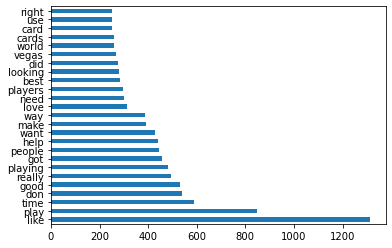

In [49]:
# plot top 20 common words
cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

#### Summary:

1. Noticed few outliers that were commonly used words. Added them to stop words so we can get better get context on words for all subreddits. 
2. Few things like game, board, fallout, rocket, league, dont, does, know, new etc were added to stop words since the name of the game can be eliminated for actual model predictions.



### 2. Distribution of words and posts

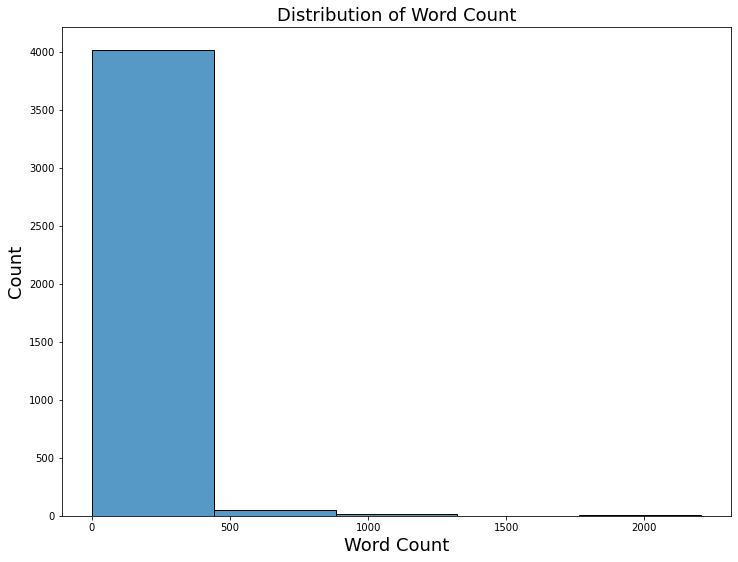

In [30]:
#histogram of word count for all subreddits
plt.figure(figsize=(12,9))
plt.title('Distribution of Word Count', size=18)
plt.xlabel('Word Count', size=18)
plt.ylabel('Count', size=18);
sns.histplot(data=reddit_df, x='post_word_count', bins=5);

#### Summary: This shows the data is skewed and around 4000 of the posts have around 450 word count and very small numbers for rest of the dataset.

### 3. Distribtion of word count for each subreddit

In [33]:
#show the word count mean for each subreddit
reddit_df[['post_word_count', 'subreddit']].groupby(['subreddit'], as_index=False).mean()

,subreddit,post_word_count
0,Fallout,85.754110
1,RocketLeague,36.693069
2,boardgames,95.381064


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


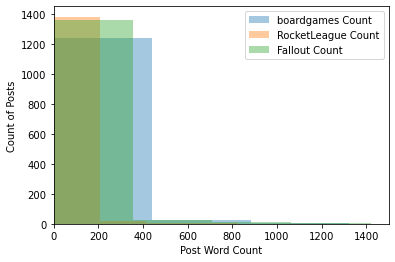

In [34]:
#show the distribution of word counts for each subreddit
sns.distplot(reddit_df[reddit_df['subreddit'] == 'boardgames']['post_word_count'], kde=False, label='boardgames Count', bins=5)
sns.distplot(reddit_df[reddit_df['subreddit'] == 'RocketLeague']['post_word_count'], kde=False, label='RocketLeague Count', bins=5)
sns.distplot(reddit_df[reddit_df['subreddit'] == 'Fallout']['post_word_count'], kde=False, label='Fallout Count', bins=5)
plt.xlim(0,1500);
plt.xlabel('Post Word Count', fontsize = 10)
plt.ylabel('Count of Posts', fontsize = 10)
plt.legend();

#### Summary: BoardGames has highest word count in the dataset, next with Fallout and RocketLeague being the third.

### 4. Distribtion of post length for each subreddit

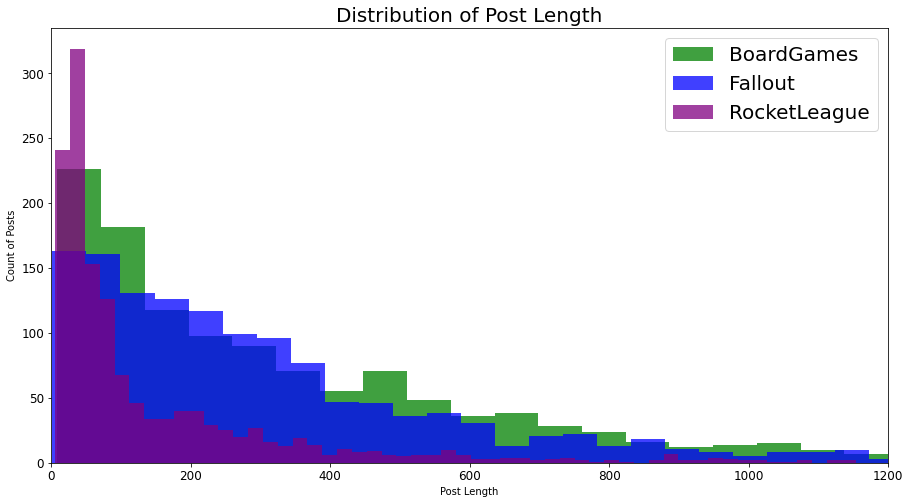

In [35]:
#plot the distribtion of the 3 different gaming post length
#Got inspired from Tim on this histogram

plt.figure(figsize = (15,8))
plt.hist(reddit_df[reddit_df['subreddit'] == 'boardgames']['post_length'], bins = 200, alpha = 0.75, label = 'BoardGames', color = 'green')
plt.hist(reddit_df[reddit_df['subreddit'] == 'Fallout']['post_length'], bins = 200, alpha = 0.75, label = 'Fallout', color = 'blue')
plt.hist(reddit_df[reddit_df['subreddit'] == 'RocketLeague']['post_length'], bins = 200, alpha = 0.75, label = 'RocketLeague', color = 'purple')
plt.xlabel('Post Length', fontsize = 10)
plt.ylabel('Count of Posts', fontsize = 10)
plt.xlim(0,1200);
plt.legend(fontsize = 20)
plt.title('Distribution of Post Length', fontsize = 20)
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

#### Summary: This shows the distribution of post length for each gaming sub reddit

### Get Bigrams

In [36]:
#Get the 2 words most commonly used by using ngram range 2,2

In [37]:
X = reddit_df['submission_text']
cvec2 = CountVectorizer(stop_words=stop_words, 
                      min_df=2,
                      ngram_range=(2,2))
cvec2.fit(X)

cvec_X2 = cvec2.transform(X)

cvec_X2_df = pd.DataFrame(cvec_X2.todense(), columns = cvec2.get_feature_names())

cvec_X2_df.sum().sort_values(ascending=False).head(10)

preview redd       104
ref kicktraq        69
need help           52
power armor         52
png webp            43
png width           43
vault tec           42
boardgames wiki     40
air roll            39
years ago           37
dtype: int64

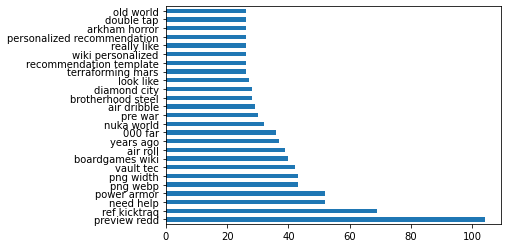

In [38]:
# plot top 20 common words
cvec_X2_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Summary:

1. Shows a view of bigrams for our dataset - most commonly 25 words.

### Get Trigrams

In [40]:
#Get the 3 words most commonly used by using ngram = 3,3

In [41]:
X = reddit_df['submission_text']
cvec3 = CountVectorizer(stop_words=stop_words, 
                      min_df=2,
                      ngram_range=(3,3))
cvec3.fit(X)

cvec_X3 = cvec3.transform(X)

cvec_X3_df = pd.DataFrame(cvec_X3.todense(), columns = cvec3.get_feature_names())

cvec_X3_df.sum().sort_values(ascending=False).head(10)

personalized recommendation template    26
boardgames wiki personalized            26
wiki personalized recommendation        26
view poll poll                          23
robots ate pizza                        18
boardgames flair_name 3a                16
accessibility concerns account          13
piece advice regarding                  13
template isn bold                       13
account check meeplelikeus              13
dtype: int64

### Summary:

- The most common 10 trigrams are shown above.


In [42]:
#Showing any Noun occurences in boardgames
[post for post in pos_tag(reddit_df[reddit_df['subreddit'] == 'boardgames']['submission_text']) if post[1] == 'NN' ][:30]

[('do codenames online', 'NN'),
 ('do My wife gave me a talkin to after finding out I went all in on the Everdell Kickstarter I know I m not the only one',
  'NN'),
 ('do Table Top Traveling Tray Kickstarter Video', 'NN'),
 ('do Drinking Quest Six Pack in the final 48 hours on Kickstarter', 'NN'),
 ('do Any idea from what game is this', 'NN'),
 ('do SF Bay Area Advocacy Group Launches Board Game', 'NN'),
 ('do John Company 2e Kickstarter Launches Pax Pamir 2e reprint metal coins also available to order',
  'NN'),
 ('ing call phone based game I ve tried to create a new type of tabletop game a phone based one much like how de profundis tells its story entirely through letters or scythe through a map those who play my game tell theirs entirely with their phones and a solitary six sided die It also manages to deal with some themes such as isolation family and insanity through various mechanics in play It s also free and features solo play that isn t just journalling New free Phone based na

### 5. Get 25 most common words used for boardgames subreddit

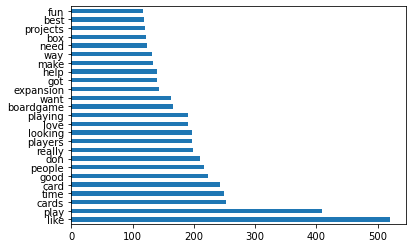

In [50]:
#Using CountVectorizer to understand the text data for boardgames and plot the data
X = reddit_df[reddit_df['subreddit'] =='boardgames']['submission_text']

cvec = CountVectorizer(stop_words=stop_words, min_df=1)

cvec.fit(X)
X = cvec.transform(X)

#validate the most common words
cvec_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

cvec_df.sum().sort_values(ascending=False).head(15)

# plot top 20 common words
cvec_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Summary:
1. As part of boardgame filtered to 25 common used words, lot of positive words have been exposed from this EDA. 
2. Postivie words such as need, best, fun, like, love, looking, expansion, want, make etc have been surfaced for boardgames.
3. Additional sentimental analysis can be performed to understand the behavior. If comments and voting can be pulled also then it might give more input to our models and make our models better.


### Next link: 
Please navigate to <a href="03_Classification_Model.ipynb" title="Models">Classification Model</a>